In [1]:
import numpy as np
import xarray as xr

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

from preprocessingTools import *

In [2]:
# Extract native calypso variables in spherical harmonic space and toroidal/poloidal components
forcings_m3=xr.open_dataset("data/calypso_t800_m3_T-B-Lorentz.nc")
forcings_mm3=xr.open_dataset("data/calypso_t800_mm3_T-B-Lorentz.nc")
velocity_mm3=xr.open_dataset("data/calypso_t800_mm3_V.nc")

This notebook transforms native calypso variables (in spherical harmonic space and toroidal/poloidal components) to their "cartesian" version, in spherical components $(r,\theta)$. Only the $m=\pm 3$ components are considered. The $\phi$ dependence of a given variable can be recovered as $F(r,\theta,\phi) = \Re(\tilde F(r,\theta)e^{3i\phi})$

# Transformation to spherical coordinates

In [3]:
# Create a meridional grid. This grid will be common to all variables from now on. 
# We choose a nonuniform grid with enhanced resolution at the poles
ngrid=300
y = np.cos(np.linspace(0.,np.pi,ngrid+2)[1:-1][::-1]) #exclude the -1 and 1 bounds to avoid divisions by 0


## Temperature

In [6]:
%%time
# Convert from (time, radius, degree) space to (time, radius, cos(latitude)) space. 
# Each quantity (in this example, temperature) is Fourier transformed in phi.
temperature_y_m3  = interp_scalar(y, forcings_m3.temperature ,  3)
temperature_y_mm3 = interp_scalar(y, forcings_mm3.temperature, -3)
#Add the m=+3 and m=-3 components
temperature_y = temperature_y_m3+temperature_y_mm3

CPU times: user 3min 37s, sys: 2min 44s, total: 6min 21s
Wall time: 6min 46s


In [ ]:
# save to netcdf
temperature_y.to_netcdf("data/data808/temperature_y300.nc")

Now we can visualize the buoyancy force on a spherical surface. We already have T as a function of t,r and y, so we simply need to differentiate in time, pick a time and radius, and multiply by $e^{im\phi}$ to get the $\phi$ dependence.

In [10]:
# Create a spherical grid for plotting
theta = np.arccos(y)
phi = np.linspace(0, 2*np.pi, ngrid)
phi_xr=xr.DataArray(phi,coords={'phi':phi},dims=['phi'])
phi, theta  = np.meshgrid(phi, theta)

# The Cartesian coordinates of the unit sphere
X = np.sin(theta) * np.cos(phi)
Y = np.sin(theta) * np.sin(phi)
Z = np.cos(theta)

In [8]:
dt_temperature_y=(temperature_y.differentiate('t_step')/(25e-7)).sel(t_step=0,radius_ID=1.48,method='nearest')
dt_temperature_yphi = np.real((dt_temperature_y.temperature_real+1j*dt_temperature_y.temperature_imag)*np.exp(1j*3*phi_xr))

Text(0.5, 0.92, 'm=3 component of $\\partial_t T$ at t=0 and r=1.48 (base of stratified layer)')

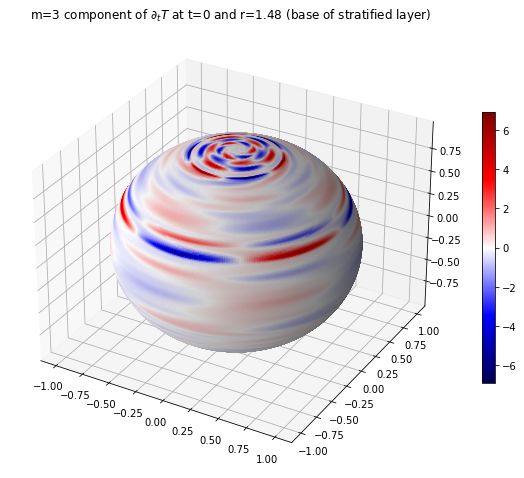

In [9]:
fig,ax = plt.subplots(1,1,figsize=(10.,10.), subplot_kw = {'projection':'3d'})
norm = clr.Normalize(vmin=dt_temperature_yphi.min(), vmax=dt_temperature_yphi.max())
surf=ax.plot_surface(X, Y, Z,  rstride=1, cstride=1, facecolors=plt.cm.seismic(norm(dt_temperature_yphi)))
m = plt.cm.ScalarMappable(cmap=plt.cm.seismic, norm=norm)
m.set_array([])
plt.colorbar(m,shrink=0.5)

ax.set_title("m=3 component of $\partial_t T$ at t=0 and r=1.48 (base of stratified layer)")


## Lorentz force, magnetic field

In [ ]:
%%time
# Convert from (time, radius, degree) space and toroidal/poloidal components to (time, radius, cos(latitude)) space and spherical components. 
# takes 25 min
Lorentz_y_m3  = interp_vector(y, forcings_m3.drop(['temperature','magnetic_field_pol','magnetic_field_tor','magnetic_field_pol_dr']).squeeze(), 3)
Lorentz_y_mm3 = interp_vector(y, forcings_mm3.drop(['temperature','magnetic_field_pol','magnetic_field_tor','magnetic_field_pol_dr']).squeeze(), -3)
# Add the m=+3 and m=-3 components
Lorentz_y = Lorentz_y_m3+Lorentz_y_mm3
# save to netcdf
Lorentz_y.to_netcdf("data/data808/Lorentz_force_y300.nc")

In [ ]:
%%time
#takes 25 min
B_y_m3  = interp_vector(y,  forcings_m3.drop(['temperature','Lorentz_force_pol','Lorentz_force_tor','Lorentz_force_pol_dr']).squeeze(), 3)
B_y_mm3 = interp_vector(y, forcings_mm3.drop(['temperature','Lorentz_force_pol','Lorentz_force_tor','Lorentz_force_pol_dr']).squeeze(), -3)
#Add the m=+3 and m=-3 components
B_y = B_y_m3+B_y_mm3
# save to netcdf
B_y.to_netcdf("data/data808/magnetic_field_y300.nc")

## Velocity

In [16]:
ngrid=300
y = np.cos(np.linspace(0.,np.pi,ngrid+2)[1:-1][::-1]) #exclude the -1 and 1 bounds to avoid divisions by 0


In [17]:
%%time
#takes 25 min
V_y_mm3 = interp_vector(y, forcings_mm3.drop(['pressure','heat_source','temperature','Lorentz_force_pol','Lorentz_force_tor','Lorentz_force_pol_dr','magnetic_field_pol','magnetic_field_tor','magnetic_field_pol_dr']).squeeze(), -3)
# save to netcdf
V_y_mm3.to_netcdf("data/data808/velocity_y300.nc")

CPU times: user 6min 5s, sys: 4min 43s, total: 10min 49s
Wall time: 12min 25s
